In [1]:
import mixmatch.models.wideresnet as models
from mixmatch.dataset.chestnut import ChestnutSubset, tf_preproc, tf_aug
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Sequence
from matplotlib import pyplot as plt
from seaborn import heatmap
import numpy as np
import pandas as pd
import torch
import os

# Count plot of labels

In [2]:
train_dataset_dir = "../chestnut_20201218_48"

In [3]:
data, keys = [], []
for species in os.listdir(train_dataset_dir):
    keys.append(species)
    data.append(len(os.listdir(os.path.join(train_dataset_dir, species))))
    print(f"{species} - {len(os.listdir(os.path.join(train_dataset_dir, species)))}")

Spathodea Campanulatum - 148
Bridelia Sp. - 132
Sterculia Parviflora - 21
Syzygium Polyanthum - 15
Clausena Excavata - 14
Alstonia Angulstiloba - 40
Cinnamomum Iners - 32
Falcataria Moluccana - 464
Ficus Variegata - 149


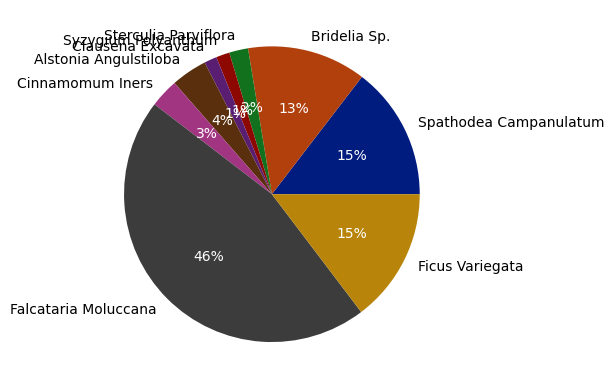

In [4]:
# importing libraries 
import matplotlib.pyplot as plt 
import seaborn 
  
# declaring exploding pie 
# explode = [0, 0.1, 0, 0, 0] 
# define Seaborn color palette to use 
palette_color = seaborn.color_palette('dark') 
  
# plotting data on chart 
_, _, autotexts = plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%') 
for autotext in autotexts:
    autotext.set_color('white')
  
# displaying chart 
plt.show() 

In [5]:
# load model
device = "cuda"
model = models.WideResNet(num_classes=9).to(device)
resume = "../Chestnut_logs/model_best.pth.tar"
checkpoint = torch.load(resume)
best_acc = checkpoint['best_acc']
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

# Confusion matrix

100%|██████████| 20/20 [00:00<00:00, 65.46it/s]


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'Spathodea Campanulatum'),
  Text(1.5, 0, 'Bridelia Sp.'),
  Text(2.5, 0, 'Sterculia Parviflora'),
  Text(3.5, 0, 'Syzygium Polyanthum'),
  Text(4.5, 0, 'Clausena Excavata'),
  Text(5.5, 0, 'Alstonia Angulstiloba'),
  Text(6.5, 0, 'Cinnamomum Iners'),
  Text(7.5, 0, 'Falcataria Moluccana'),
  Text(8.5, 0, 'Ficus Variegata')])

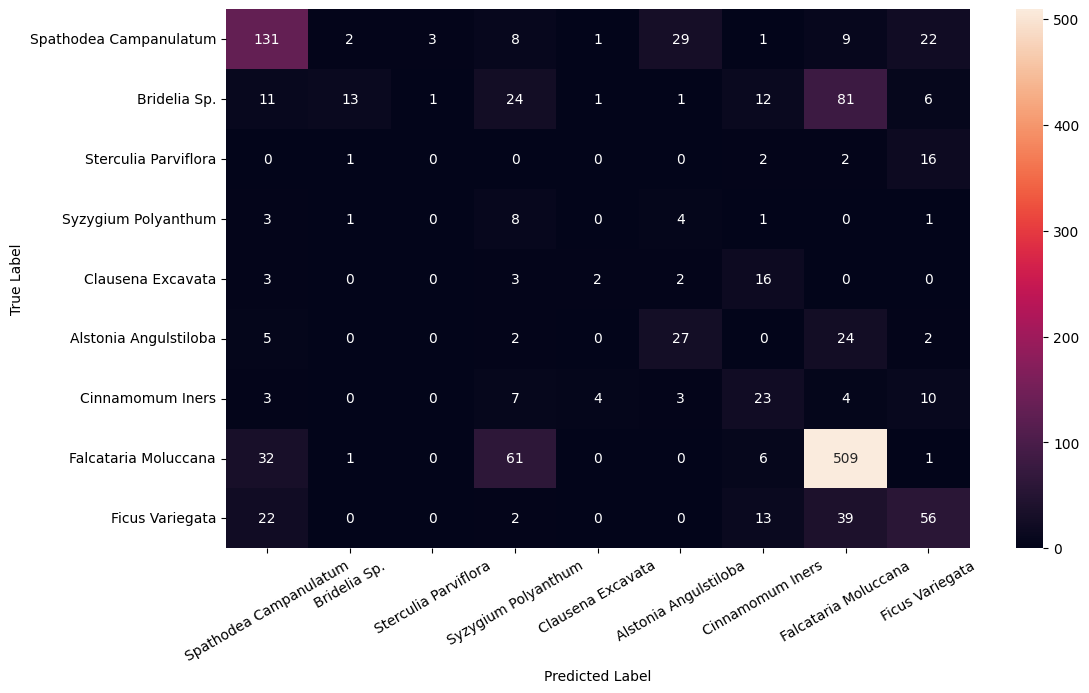

In [15]:
home_dir = "chestnut_20210510_43m_48"
mean = np.array([[[[0.51550424, 0.7849136,  0.7106589,  0.3434312,  0.27874488, 0.23526585, 0.45951512, 0.59085524]]]])
std = np.array([[[[0.13252501, 0.16142327, 0.16173103, 0.12343683, 0.13712455, 0.12067181, 0.15292309, 0.15441005]]]])
dl_args = dict(
    batch_size=64,
    num_workers=2,
)
test_ds = ChestnutSubset(
    root=f"../{home_dir}",
    transform=tf_preproc,
    stats=(mean, std),
)

test_dl = DataLoader(test_ds, shuffle=False, **dl_args)
y_trues, y_preds = [], []
model.eval()
with torch.no_grad():
    for x, y in tqdm(test_dl):
        # TODO: Pretty hacky but this is for the train loader.
        if isinstance(x, Sequence):
            x = x[0]

        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)
        y_trues.append(y)
        y_preds.append(preds)

y_trues = torch.cat(y_trues)
y_preds = torch.cat(y_preds)
# Plot the confusion matrix
cm = confusion_matrix(y_trues.cpu().numpy(), y_preds.cpu().numpy())

df_cm = pd.DataFrame(cm, index = [i for i in test_ds.species_map],
                     columns = [i for i in test_ds.species_map])
df_final = df_cm.div(df_cm.sum(axis=1), axis=0)

plt.figure(figsize = (12,7))
heatmap(cm, xticklabels=test_ds.species_map, yticklabels=test_ds.species_map, annot=True, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=30)
        

In [16]:
import torch.nn as nn 
from torchmetrics.functional import accuracy

def validate(
    *,
    valloader: DataLoader,
    model: nn.Module,
    device: str,
):
    n = []
    accs = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(valloader):
            # TODO: Pretty hacky but this is for the train loader.
            if isinstance(x, Sequence):
                x = x[0]

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            preds = torch.argmax(y_pred, dim=1)

            # TODO: Technically, we shouldn't * 100, but it's fine for now as
            #  it doesn't impact training
            acc = (
                accuracy(
                    y_pred,
                    y,
                    task="multiclass",
                    num_classes=y_pred.shape[1],
                )
                * 100
            )
            accs.append(acc.item())
            n.append(x.size(0))

    # return weighted mean
    return (
        sum([top * n for top, n in zip(accs, n)]) / sum(n),
    )

accs = validate(model=model, valloader=test_dl, device="cuda")

100%|██████████| 20/20 [00:00<00:00, 108.24it/s]


# Grid mapping

In [17]:
from collections import defaultdict

test_dataset_dir = "../chestnut_20210510_43m_48"
species = "Spathodea Campanulatum"
size = 48

from typing import Dict
from torchvision import transforms
import torch.nn as nn 

totensor = transforms.ToTensor()

def create_mask(model: nn.Module,
                cell: np.ndarray,
                device: str):
    cell = (cell - mean) / std
    cell = cell.squeeze(0)
    cell = tf_preproc(cell)
    cell = torch.unsqueeze(cell, 0)
    cell = cell.to(device, dtype=torch.float)
    model.eval()
    with torch.no_grad():
        pred = model(cell)
        pred_cls = torch.argmax(pred)
    return torch.full((48, 48, 1), pred_cls)


def calc_confusion(species: str, mask: np.ndarray):
    label = test_ds.species_map.index(species)
    num_correct = (mask == label).sum()
    total_preds = mask.shape[0] * mask.shape[1]
    return num_correct / total_preds


def reconstruct_image_from_cells(model: nn.Module,
                                 test_dataset_dir: str,
                                 size: int = 48) -> Dict[str, Dict[int, np.ndarray]]:
    """
    returns spec_images
    which is a dictionary mapping each species to list of tuples
    with each tuple containing the reconstructed image and its prediction mask
    """
    spec_images = {}
    for species in os.listdir(test_dataset_dir):
        dims, cells = defaultdict(lambda: (-1, -1)), defaultdict(lambda: dict())
        species_path = os.path.join(test_dataset_dir, species)
        # get species label
        label = test_ds.species_map.index(species)
        # preprocessing
        # extracts dimensions to reconstruct original image 
        for fname in os.listdir(species_path):
            _split_name = fname.split("_")
            idx, i, j = int(_split_name[1]), int(_split_name[2]), int(_split_name[3][:-4])
            cell = np.load(os.path.join(species_path, fname))
            mask = create_mask(model, cell, "cuda")
            if cell.shape[-1] == 8:
                cell = cell[..., [2, 1, 0]]
            cells[idx][(i, j)] = (cell, mask)
            max_x, max_y = max(i, dims[idx][0]), max(j, dims[idx][1])
            dims[idx] = (max_x, max_y)

        imgs = {}
        for idx, (n_r, n_c) in dims.items():
            img_arr = np.zeros(((n_c+1) * size, (n_r+1) * size, 3))
            mask_arr = np.zeros(((n_c+1) * size, (n_r+1) * size, 1))
            for (i, j), (cell, mask) in cells[idx].items():
                img_arr[j*size:(j+1)*size, i*size:(i+1)*size, :] = cell
                mask_arr[j*size:(j+1)*size, i*size:(i+1)*size, :] = mask
            confusion = calc_confusion(species, mask_arr)
            imgs[idx] = (img_arr, mask_arr, confusion)
        spec_images[species] = imgs
    return spec_images

imgs = reconstruct_image_from_cells(model=model, test_dataset_dir=test_dataset_dir)


In [18]:
imgs["Alstonia Angulstiloba"].keys()

dict_keys([13, 16])

In [19]:
test_ds.species_map.index("Alstonia Angulstiloba")

5

In [70]:
from pylab import *


def _counts(species: str, index: int):
    unique, counts = np.unique(imgs[species][index][1], return_counts=True)
    return dict(zip(unique, counts))

def plot_visuals(fig, ax, results, cmap, cell_size: int = 48):
    species, img, mask, confusion = results
    mask = mask.squeeze()

    # Grid lines at these intervals (in pixels)
    # dx and dy can be different
    dx, dy = cell_size, cell_size

    # Custom (rgb) grid color
    grid_color = [0,0,0]

    # Modify the image to include the grid
    img[:,::dy,:] = grid_color
    img[::dx,:,:] = grid_color

    ax[0].imshow(img)
    ax[1].imshow(img)
    # put those patched as legend-handles into the legend
    plot = ax[1].imshow(mask, cmap=cmap, interpolation='bilinear', vmax=8, vmin=0, alpha=0.7)
    fig.tight_layout()
    return plot

def most_confused(imgs, top_n: int = 5):
    results = []
    for species, indices in imgs.items():
        for _, (img, mask, confusion) in indices.items():
            results.append((species, img, mask, confusion))

    results.sort(key=lambda x: x[-1])
    fig, ax = plt.subplots(top_n, 2, figsize=(50, 70))
    cmap = cm.get_cmap('jet', 9)    # 9 discrete colors
    for i in range(top_n):
        ax[i][0].set_title(f"{results[i][0]}, {(results[i][-1] * 100):.2f}", fontsize=50)
        plot = plot_visuals(fig, ax[i], results[i], cmap)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(plot, cax=cbar_ax)
    # cbar.ax.set_xticklabels(test_ds.species_map)  # vertically oriented colorbar
    cbar.ax.set_yticks(ticks=np.arange(len(test_ds.species_map)), 
                       labels=test_ds.species_map,
                       fontsize="30", va="center")


/tmp/ipykernel_20120/2319837362.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 9)    # 9 discrete colors


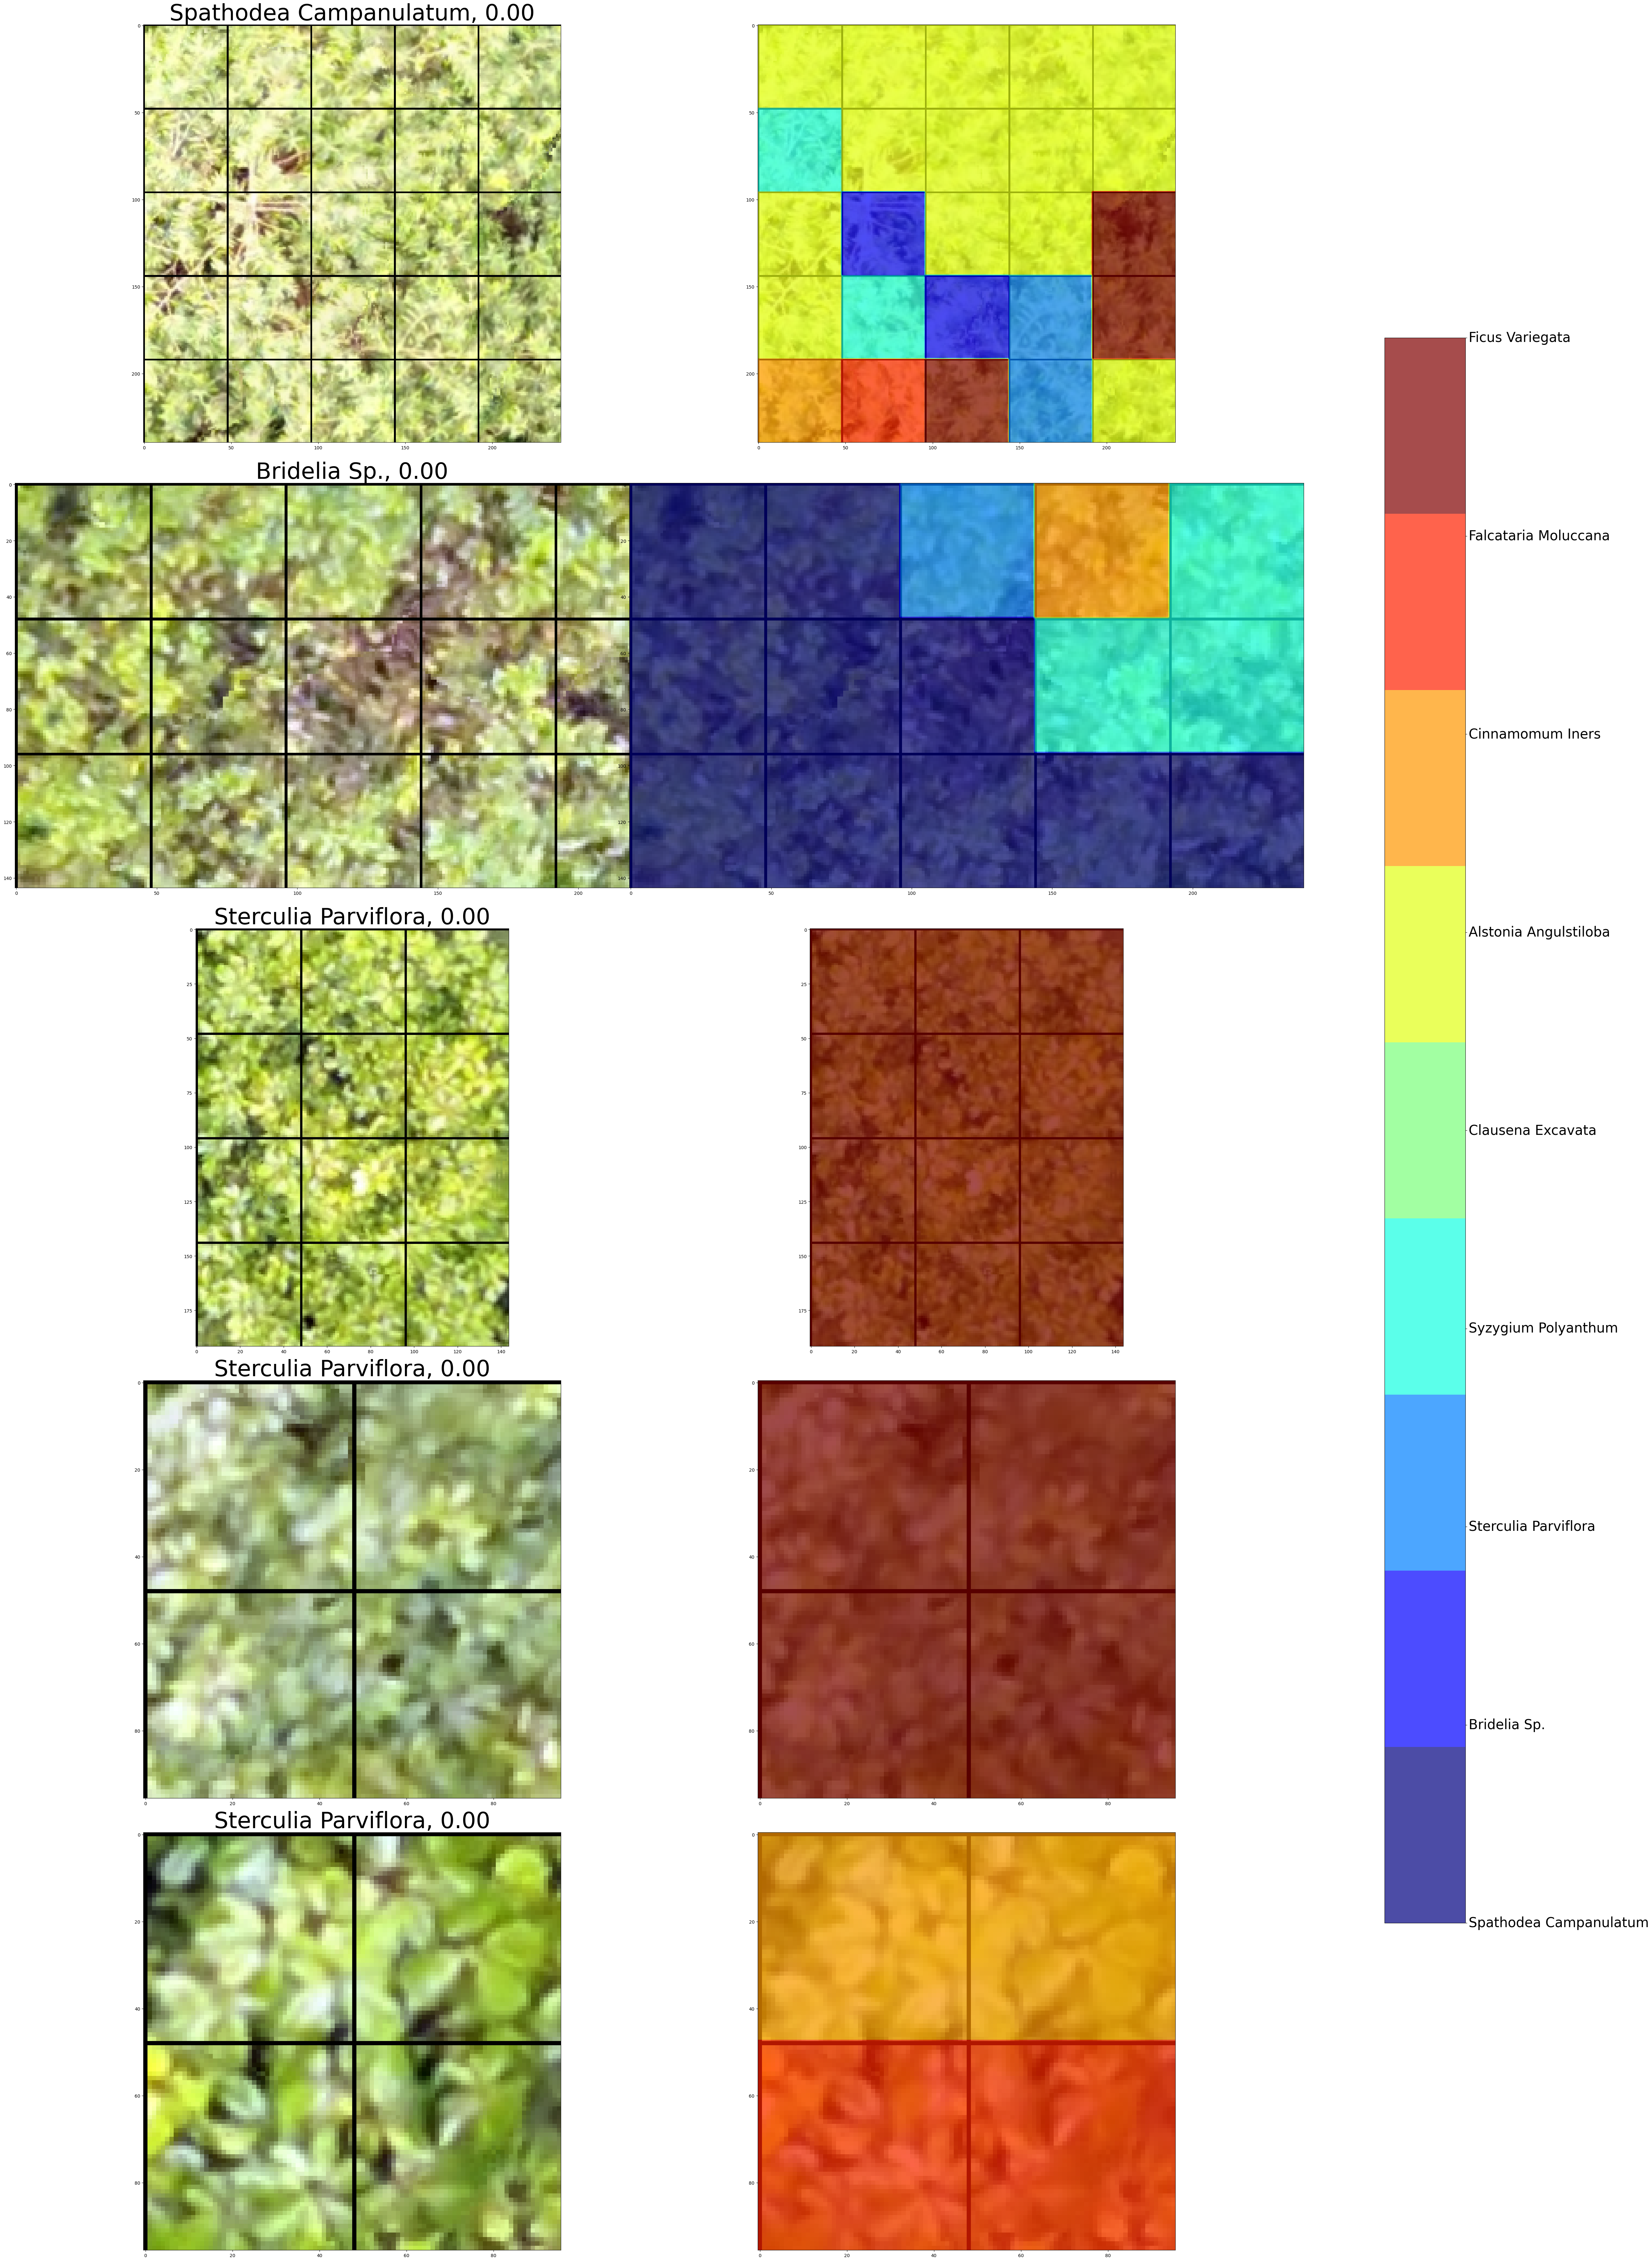

In [72]:
most_confused(imgs, top_n=5)